In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [2]:
outliers_df = pd.read_csv('outliers-data.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   prev_sold_date  7757 non-null   object 
 6   price           7757 non-null   float64
dtypes: float64(6), object(1)
memory usage: 424.3+ KB


In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7757 entries, 0 to 7756
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             7757 non-null   float64
 1   bath            7757 non-null   float64
 2   acre_lot        7757 non-null   float64
 3   zip_code        7757 non-null   float64
 4   house_size      7757 non-null   float64
 5   price           7757 non-null   float64
 6   prev_sold_year  7757 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 424.3 KB


In [5]:
zip_lon_lat = pd.read_csv("county.csv")
zip_lon_lat.head()


,Unnamed: 0,zip_code,latitude,longitude,zip_code_str,county
0,0,7001,40.582316,-74.271506,7001,16
1,1,7002,40.662338,-74.110275,7002,2
2,2,7003,40.809128,-74.187155,7003,2
3,3,7004,40.882508,-74.304593,7004,19
4,4,7005,40.932771,-74.417304,7005,19


In [6]:
merged_df = pd.merge(outliers_df, zip_lon_lat, how="inner", on="zip_code")
merged_df.tail()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,Unnamed: 0,latitude,longitude,zip_code_str,county
7749,5.0,4.0,0.91,8848.0,0.0,485000.0,2017,568,40.594266,-75.096659,8848,11
7750,4.0,3.0,2.17,8825.0,0.0,510000.0,2016,553,40.514169,-75.027112,8825,11
7751,3.0,2.0,0.12,7012.0,0.0,499000.0,2021,10,40.848398,-74.160266,7012,2
7752,3.0,3.0,0.13,7012.0,0.0,530000.0,2022,10,40.848398,-74.160266,7012,2
7753,4.0,3.0,0.11,7640.0,0.0,720000.0,2016,171,40.991681,-73.980202,7640,15


In [7]:
features = ["latitude","longitude","bed","bath","house_size","prev_sold_year","acre_lot"]
num_features_to_select = len(features)-1
random_state_value = 42

In [8]:
#"bed","bath","acre_lot","latitude","longitude","county","house_size","prev_sold_year"
X = merged_df[features]
y = merged_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

In [9]:
#"LinearRegression","RFE","SequentialFeatureSelector","SelectFromModel","PolynomialBestFeatures","PolynomialFeatures"
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[]}

In [10]:

def print_more_stuff(title, y_param, predict_param):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)    
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)

In [11]:
lgr = LinearRegression(fit_intercept=False)
lgr_model = lgr.fit(X_train,y_train)
lgr_predict = lgr_model.predict(X_test)
print_more_stuff("Linear Regression", y_test, lgr_predict)

Linear Regression EVS = 0.414227475
Linear Regression MSE = 103,792,735,447.580704
Linear Regression MAE = 213,914.508239
Linear Regression R2 = 0.413890


In [12]:
lgr_rfe = RFE(LinearRegression(), n_features_to_select=num_features_to_select)
lgr_rfe.fit(X, y)
lgr_rfe_selected_features = lgr_rfe.get_support()
print('The selected features are:', list(X.columns[lgr_rfe_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'prev_sold_year', 'acre_lot']


In [13]:
X_rfe = merged_df[list(X.columns[lgr_rfe_selected_features])]
y_rfe = merged_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [14]:
lgr_rfe = LinearRegression(fit_intercept=False)
lgr_rfe_model = lgr_rfe.fit(X_rfe_train,y_rfe_train)
lgr_rfe_predict = lgr_rfe_model.predict(X_rfe_test)

print_more_stuff("Recursive Feature Elimination", y_test, lgr_rfe_predict)

Recursive Feature Elimination EVS = 0.413218090
Recursive Feature Elimination MSE = 103,983,038,917.955841
Recursive Feature Elimination MAE = 214,164.071420
Recursive Feature Elimination R2 = 0.412816


In [15]:
lgr_sfs = SequentialFeatureSelector(LinearRegression(), n_features_to_select=num_features_to_select)
lgr_sfs.fit(X, y)
lgr_sfs_selected_features = lgr_sfs.get_support()
print('The selected features are:', list(X.columns[lgr_sfs_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size', 'prev_sold_year']


In [16]:
X_sfs = merged_df[list(X.columns[lgr_sfs_selected_features])]
y_sfs = merged_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [17]:
lgr_sfs = LinearRegression(fit_intercept=False)
lgr_sfs_model = lgr_sfs.fit(X_sfs_train,y_sfs_train)
lgr_sfs_predict = lgr_sfs_model.predict(X_sfs_test)
print_more_stuff("Sequential Feature Selector", y_test, lgr_sfs_predict)

Sequential Feature Selector EVS = 0.412211250
Sequential Feature Selector MSE = 104,153,208,777.124252
Sequential Feature Selector MAE = 214,237.384104
Sequential Feature Selector R2 = 0.411855


In [18]:
lgr_sfm = SelectFromModel(estimator=LinearRegression(), threshold=1000)
lgr_sfm.fit(X,y)
lgr_sfm_selected_features = lgr_sfm.get_support()
print('The selected features are:', list(X.columns[lgr_sfm_selected_features]))

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'prev_sold_year', 'acre_lot']


In [19]:
X_sfm = merged_df[list(X.columns[lgr_sfm_selected_features])]
y_sfm = merged_df["price"]
X_sfm_train, X_sfm_test, y_sfm_train, y_sfm_test = train_test_split(X_sfm, y_sfm, test_size=0.3, random_state=random_state_value)

In [20]:
lgr_sfm = LinearRegression(fit_intercept=False)
lgr_sfm.fit(X_sfm_train,y_sfm_train)
lgr_sfm_predict = lgr_sfm.predict(X_sfm_test)
print_more_stuff("Select From Model",y_sfm_test,lgr_sfm_predict)

Select From Model EVS = 0.413218090
Select From Model MSE = 103,983,038,917.955841
Select From Model MAE = 214,164.071420
Select From Model R2 = 0.412816


In [21]:
lgr_predict_df = pd.DataFrame(lgr_predict).reset_index()
lgr_predict_df.rename(columns={0: "prediction"},inplace=True)

lgr_sfm_predict_df = pd.DataFrame(lgr_sfm_predict).reset_index()
lgr_sfm_predict_df.rename(columns={0: "prediction"},inplace=True)

lgr_sfs_predict_df = pd.DataFrame(lgr_sfs_predict).reset_index()
lgr_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

lgr_rfe_predict_df = pd.DataFrame(lgr_rfe_predict).reset_index()
lgr_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

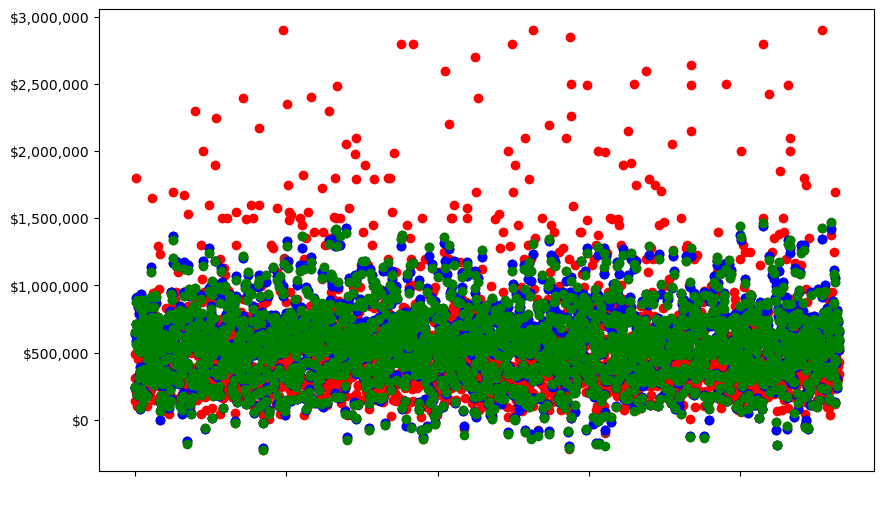

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(lgr_predict_df.index,lgr_predict_df["prediction"], color="black")
plt.scatter(lgr_sfm_predict_df.index,lgr_sfm_predict_df["prediction"], color="brown")
plt.scatter(lgr_rfe_predict_df.index,lgr_rfe_predict_df["prediction"], color="blue")
plt.scatter(lgr_sfs_predict_df.index,lgr_sfs_predict_df["prediction"], color="green")
plt.show()

In [23]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score
model,,,,
Linear Regression,0.414227475,"213,914.508239","103,792,735,447.580704",0.413890
Recursive Feature Elimination,0.413218090,"214,164.071420","103,983,038,917.955841",0.412816
Sequential Feature Selector,0.412211250,"214,237.384104","104,153,208,777.124252",0.411855
Select From Model,0.413218090,"214,164.071420","103,983,038,917.955841",0.412816
